# Corn Diseases Detection Model Training - VGG-19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Paths to dataset

In [2]:
train_dir = "../Corn Dataset/train"
test_dir = "../Corn Dataset/test"

# Parameters

In [4]:
img_height, img_width = 224, 224  
batch_size = 32
num_classes = len(os.listdir(train_dir))

# Count original dataset size

In [6]:
original_train_size = sum([len(files) for _, _, files in os.walk(train_dir)])
original_test_size = sum([len(files) for _, _, files in os.walk(test_dir)])
print(f"Original Training Dataset Size: {original_train_size} images")
print(f"Original Testing Dataset Size: {original_test_size} images")


Original Training Dataset Size: 5940 images
Original Testing Dataset Size: 660 images


# Data augmentation and preprocessing

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5940 images belonging to 6 classes.
Found 660 images belonging to 6 classes.


# Checking the Available Classes

In [9]:
class_names = train_data.class_indices
n_classes = len(class_names)
print(n_classes, class_names)

6 {'Corn___Common_Rust': 0, 'Corn___Gray_Leaf_Spot': 1, 'Corn___Healthy': 2, 'Corn___Northern_Leaf_Blight': 3, 'Corn___Northern_Leaf_Spot': 4, 'Corn___Phaeosphaeria_Leaf_Spot': 5}


# VGG-19 model setup

In [11]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 58s 1us/step


# Compile model

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks: Early stopping and learning rate scheduler

In [14]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train model

In [18]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1297s 7s/step - accuracy: 0.6103 - loss: 1.9985 - val_accuracy: 0.8727 - val_loss: 0.3237 - learning_rate: 0.0010
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1309s 7s/step - accuracy: 0.8003 - loss: 0.5266 - val_accuracy: 0.9061 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1255s 7s/step - accuracy: 0.8184 - loss: 0.4642 - val_accuracy: 0.8848 - val_loss: 0.3440 - learning_rate: 0.0010
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1258s 7s/step - accuracy: 0.8251 - loss: 0.4454 - val_accuracy: 0.9000 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1253s 7s/step - accuracy: 0.8355 - loss: 0.4179 - val_accuracy: 0.9076 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1286s 7s/step - accuracy: 0.8435 - loss: 0.4345 - val_accuracy: 0.9152 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1237s 7s/step - accuracy: 0.8436 - l

# Save model and training history


In [19]:
model.save("vgg19_model.keras")
np.save("vgg19_history.npy", history.history)

# Plot accuracy and loss graphs

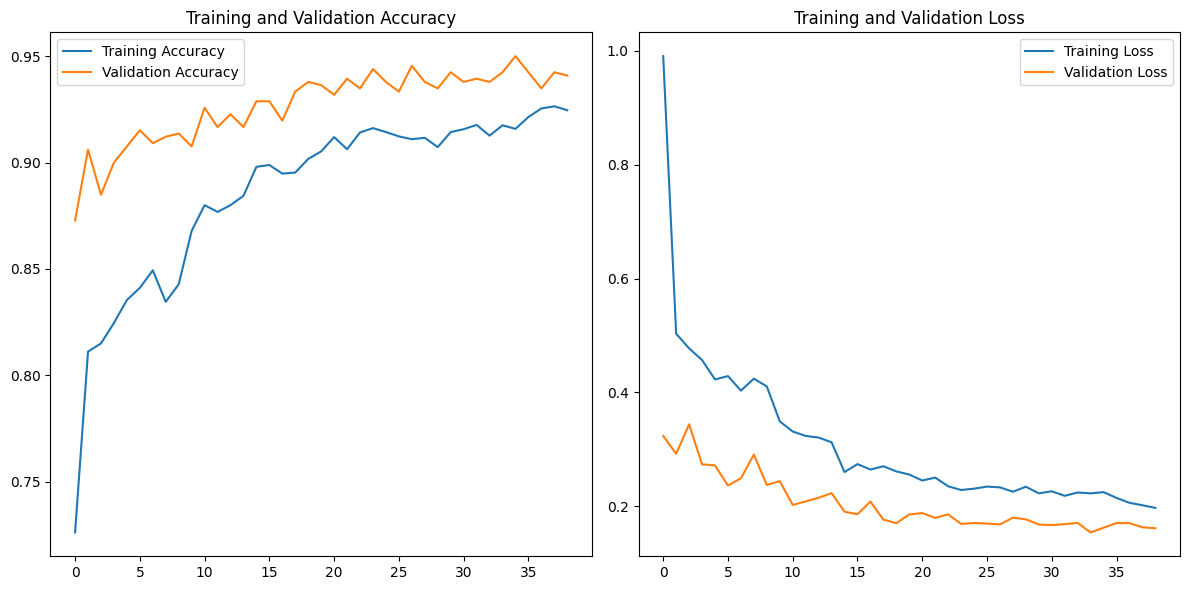

In [51]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.savefig("VGG-19_Accuracy&Loss_Graphs.png", dpi=300)

    plt.show()

plot_training_history(history)


# Evaluate model


In [21]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.9413 - loss: 0.1576
Test Accuracy: 94.24%


# Confusion matrix

21/21 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step


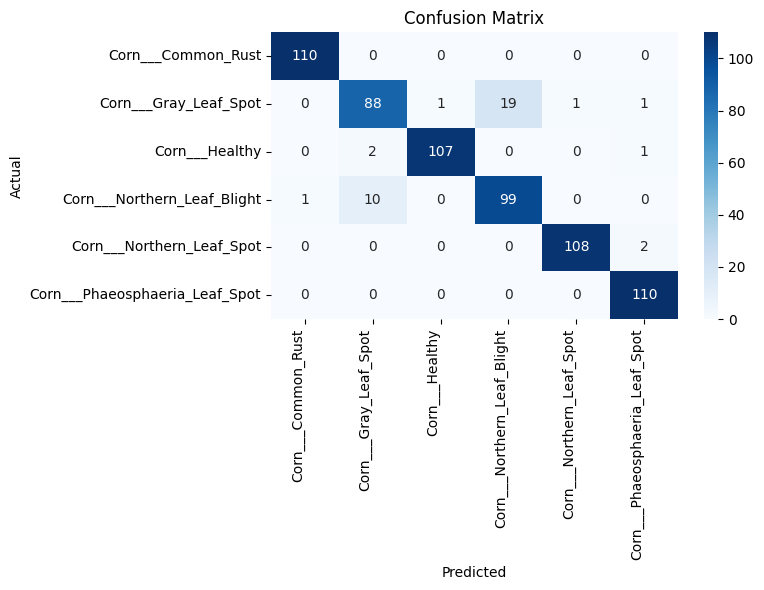

In [24]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()  
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# Classification report

In [50]:
report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())
print(report)

                                precision    recall  f1-score   support

            Corn___Common_Rust       0.99      1.00      1.00       110
         Corn___Gray_Leaf_Spot       0.88      0.80      0.84       110
                Corn___Healthy       0.99      0.97      0.98       110
   Corn___Northern_Leaf_Blight       0.84      0.90      0.87       110
     Corn___Northern_Leaf_Spot       0.99      0.98      0.99       110
Corn___Phaeosphaeria_Leaf_Spot       0.96      1.00      0.98       110

                      accuracy                           0.94       660
                     macro avg       0.94      0.94      0.94       660
                  weighted avg       0.94      0.94      0.94       660



# Model predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


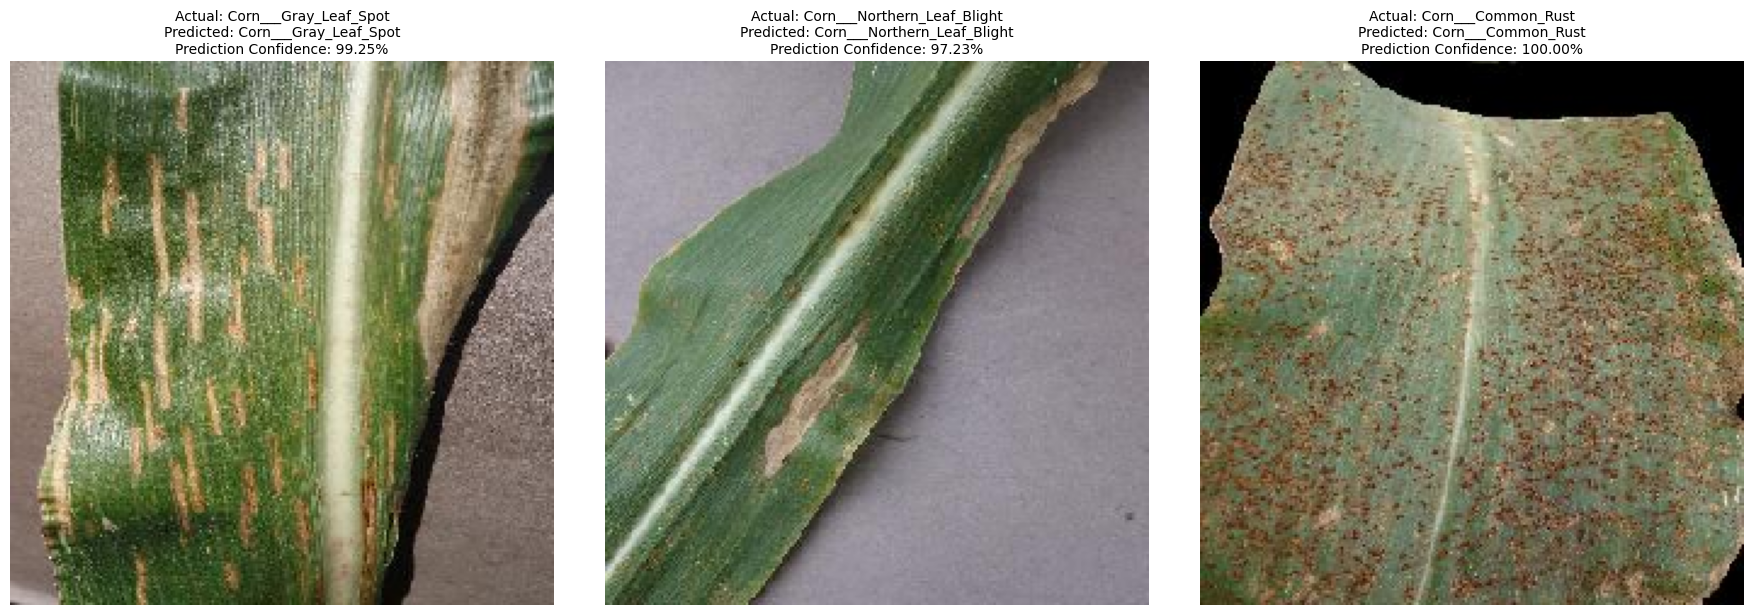

In [47]:
def predict_random_images(model, test_dir, class_indices):
    """
    Predict three random images from the test dataset, display predictions and confidence.
    """
    
    class_labels = {v: k for k, v in class_indices.items()}
    
    selected_classes = random.sample(os.listdir(test_dir), 3)
   
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

    for ax, class_name in zip(axes, selected_classes):
        
        class_dir = os.path.join(test_dir, class_name)
        image_files = os.listdir(class_dir)
        
        img_name = random.choice(image_files)
        img_path = os.path.join(class_dir, img_name)
        
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        
        ax.imshow(img)
        ax.set_title(f"Actual: {class_name}\nPredicted: {predicted_class}\nPrediction Confidence: {confidence:.2f}%", fontsize=10)
        ax.axis("off")

    plt.tight_layout()  
    plt.savefig("predictions_VGG-19.png", bbox_inches="tight")  
    plt.show()


predict_random_images(model, test_dir, test_data.class_indices)
